# `fmri-1`: fMRI visualization

This lab walks through the visualization of several types of fMRI data, including anatomical (T1-weighted) images, functional (T2*-weighted BOLD) images, and masks. We'll walk through several types of visualization for volumetric images, surface images, and time series data. We'll use two example datasets provided via [`nilearn`](https://nilearn.github.io/): [Haxby et al., 2001](https://doi.org/10.1126/science.1063736) and [Thirion et al., 2014](https://doi.org/10.1007/978-3-319-10470-6_92). For this demo, we'll need to install `nilearn` in our `conda`environment using `pip` (if you don't already have it). Run the following two commands on the command line: `conda activate neu502b` followed by `pip install nilearn`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from nilearn import datasets
from nilearn.plotting import (plot_anat, plot_epi, plot_roi,
                              plot_glass_brain, plot_stat_map,
                              plot_surf_stat_map, plot_img_on_surf)
from nilearn.image import mean_img
from nilearn.surface import vol_to_surf
from nilearn.masking import apply_mask

If you're working on the PNI server, you can set the download directory to the following class directory to avoid downloading the same data multiple times. If you're working on your local machine, set `data_dir` to a directory you're comfortable storing data (e.g. `~/neu502b`).

In [2]:
data_dir = '/usr/people/km3199/neu-502/data'

### Visualizing anatomical and functional data from Haxby et al., 2001
We'll start by download some sample data from [Haxby et al., 2001](https://doi.org/10.1126/science.1063736) provided by [PyMVPA](http://www.pymvpa.org/). In this experiment, participants viewed images of common objects such as faces, houses, cats, chairs, etc. This dataset was used to demonstrate that visual object category information is encoded in distributed patterns of activity in ventral temporal cortex and played an important role in popularizing multivariate pattern analysis (MVPA).

In [3]:
haxby_dataset = datasets.fetch_haxby(data_dir=data_dir,
                                     fetch_stimuli=True)

[fetch_haxby] Dataset found in /usr/people/km3199/neu-502/data/haxby2001

First, use `plot_anat` to plot the anatomical image provided with this sample subject. This is a single 3-dimensional structural image where e.g. CSF is dark and fat/bone are bright. The left panel displays the *coronal* view, the middle panel displays the *sagittal* view, and the right panel displays the *axial* view. Adjust the `cut_coords` (*x*, *y*, *z*) variable to change slices. Here we set the `vmin` and `vmax` to `0` and `200` arbitrarily to make the contrast more visible.

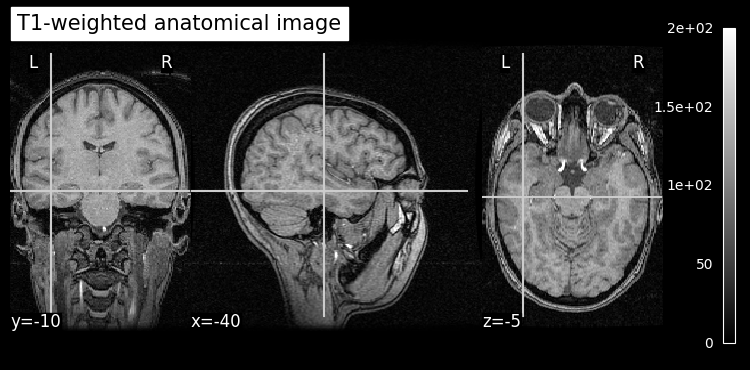

In [4]:
# Plot the anatomical image
cut_coords = (-40, -10, -5)
vmin, vmax = 0, 200
plot_anat(haxby_dataset.anat[0], cut_coords=cut_coords,
          vmin=vmin, vmax=vmax, title='T1-weighted anatomical image');

Next, we'll visualize the raw functional (BOLD) data. The BOLD data is a 4-dimensional image where the last dimension is time. For this sample dataset, the scan is 1452 time points (TRs) long. Use `mean_img` to average over time and show a single mean BOLD image with `plot_epi`. Adjust the `cut_coords` variable to view different slices of the image.

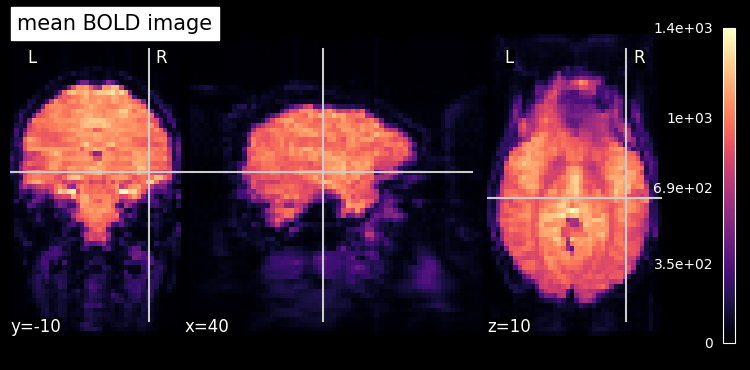

In [5]:
# Plot the mean EPI image
cut_coords = (40, -10, 10)
plot_epi(mean_img(haxby_dataset.func[0]), cut_coords=cut_coords,
         cmap='magma', title='mean BOLD image')

Now, we'll load in a "mask" dataset (`.mask_vt`). This anatomically-defined mask captures voxels in ventral temporal (VT) cortex, a common region-of-interest (ROI) in extrastriate visual cortex thought to encode visual category information. Plot the VT mask as an overlay on the anatomical image using `plot_roi`.

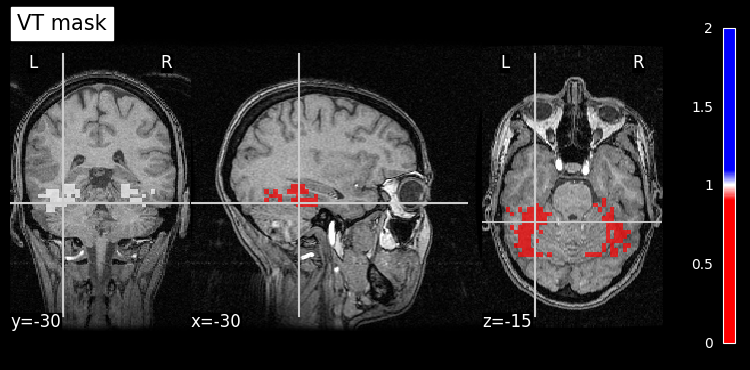

In [6]:
# Load and visualize VT mask
mask_vt = haxby_dataset.mask_vt[0]
cut_coords = (-30, -30, -15)
plot_roi(mask_vt, bg_img=haxby_dataset.anat[0], cut_coords=cut_coords,
         dim=-1.3, cmap='bwr_r', title='VT mask')

Nilearn has a variety of plotting functions. For example, try plotting this ROI as a contour using `plot_anat` followed by the `.add_contours` method.

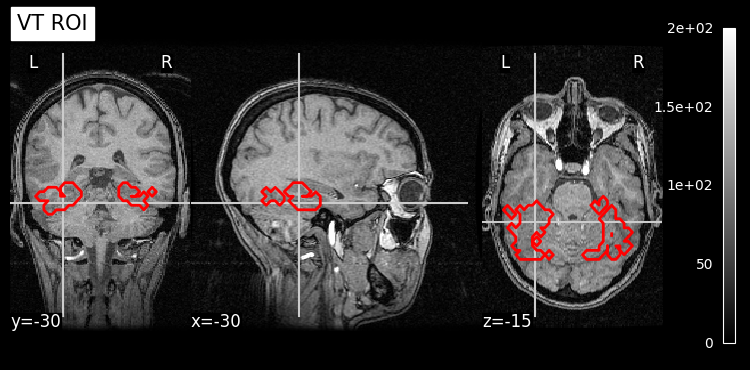

In [7]:
# Plot VT mask contours
vmin, vmax = 0, 200
anatomical_fig = plot_anat(haxby_dataset.anat[0], vmin=vmin, vmax=vmax,
                     cut_coords=cut_coords, title='VT ROI');
anatomical_fig.add_contours(mask_vt, antialiased=True, linewidths=2,
                      levels=0, colors='red')

Now we'll load two more functionally-defined masks capturing areas of ventral temporal cortex that are highly responsive to face images (`.mask_face`) and highly responsive to house images (`.mask_house`). You should see that there are several face-responsive areas and that they are located laterally relative to more medial house-responsive areas.

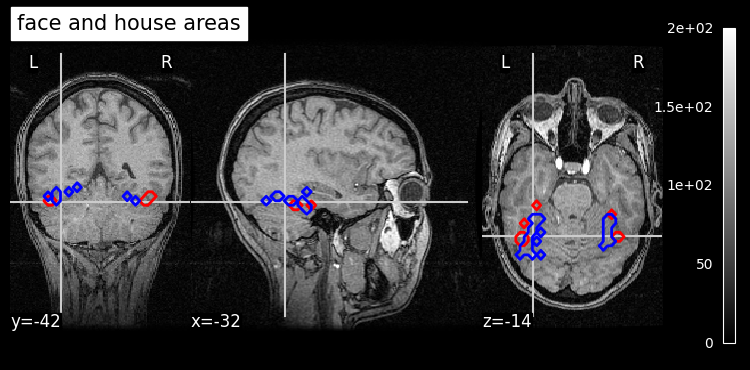

In [8]:
# Plot maximally face- and house-responsive voxels
mask_face = haxby_dataset.mask_face[0]
mask_house = haxby_dataset.mask_house[0]

vmin, vmax = 0, 200
cut_coords = (-32, -42, -14)
anat_fig = plot_anat(haxby_dataset.anat[0], vmin=vmin, vmax=vmax,
                     cut_coords=cut_coords, title='face and house areas');
anat_fig.add_contours(mask_face, antialiased=True, linewidths=2,
                      levels=0, colors='red')
anat_fig.add_contours(mask_house, antialiased=True, linewidths=2,
                      levels=0, colors='blue')

With `apply_mask`, you can use these masks to extract time series data from the functional image. We can inspect the shape of these arrays to confirm that the face-responsive mask contains 30 voxels, the house-responsive mask contains 118 voxels, and they are both 1452 time points long.

In [9]:
# Extract voxel time series for ROIs
face_info = apply_mask(haxby_dataset.func[0], mask_face)
house_info = apply_mask(haxby_dataset.func[0], mask_house)
print(f"Face data shape: {face_info.shape}")
print(f"House data shape: {house_info.shape}")

Face data shape: (1452, 30)
House data shape: (1452, 118)


Next, average the time series across voxels in each area, z-score the average time series, and plot the raw BOLD time series for face- and house-selective areas.

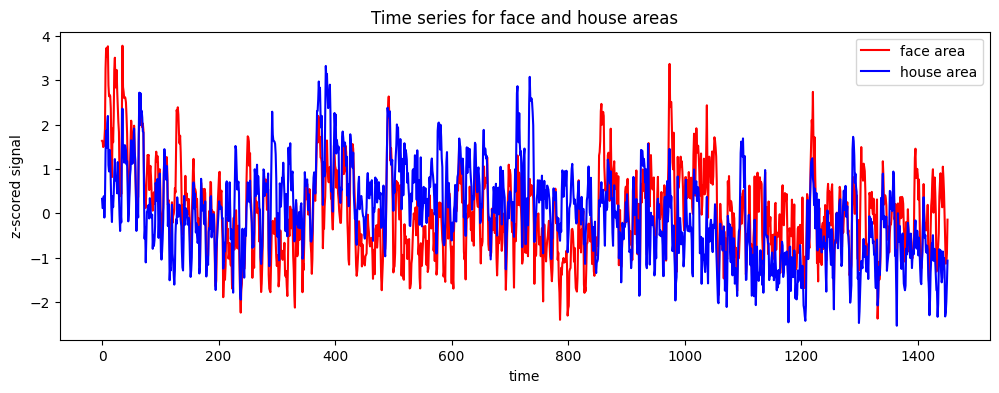

In [10]:
# Average and plot mean ROI time series
face_time_series = zscore(np.mean(face_info, axis=1))
house_time_series = zscore(np.mean(house_info, axis=1))

fig = plt.figure(figsize=(12, 4))
plt.plot(face_time_series, color='red')
plt.plot(house_time_series, color='blue')
plt.xlabel('time')
plt.ylabel('z-scored signal')
plt.title('Time series for face and house areas')
plt.legend(['face area', 'house area'])
plt.show()

Part of the beauty of interacting with brain data in Python is we can use the same environment for other purposes as well. For example, we can also use `matplotlib` to visualize the image stimuli accompanying this dataset.

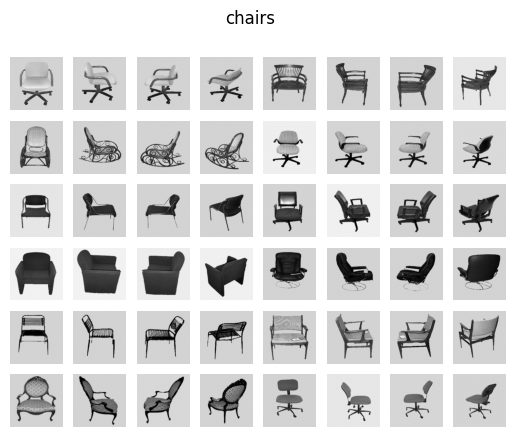

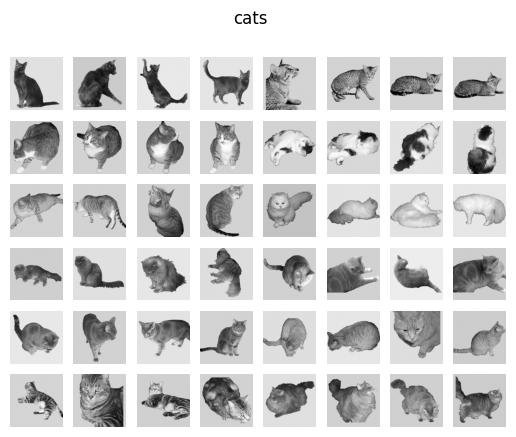

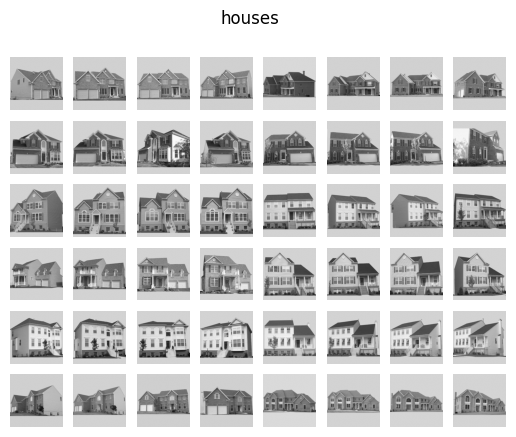

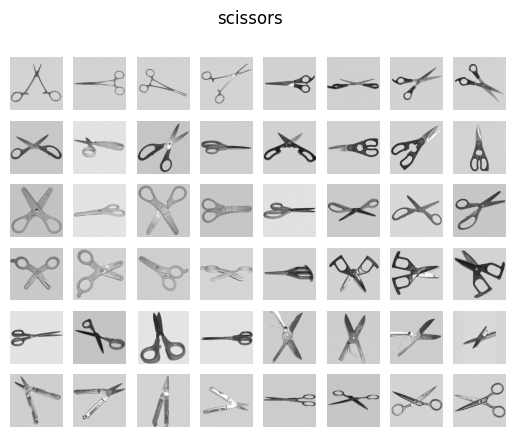

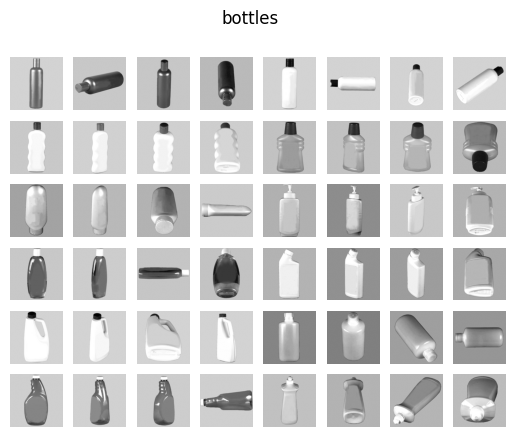

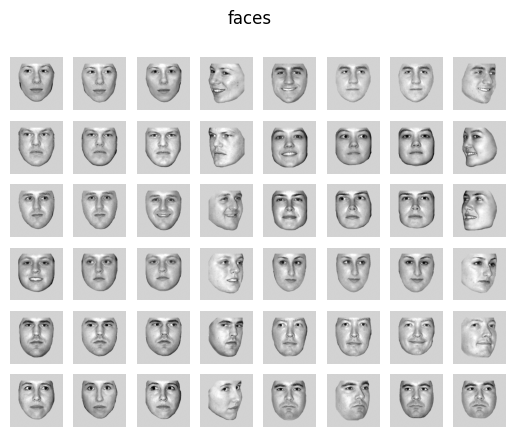

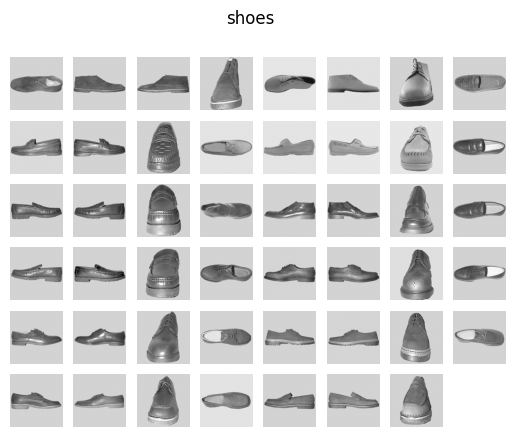

In [11]:
haxby_stimuli = haxby_dataset.stimuli
for stimulus_category in haxby_stimuli:
    
    # Skip control images (there are too many)
    if stimulus_category != 'controls':

        filenames = haxby_stimuli[stimulus_category]
        fig, axes = plt.subplots(6, 8)
        fig.suptitle(stimulus_category)
        for img_path, ax in zip(filenames, axes.ravel()):
            ax.imshow(plt.imread(img_path), cmap=plt.cm.gray)
        for ax in axes.ravel():
            ax.axis("off")

### Visualizing a statistical map from Thirion et al., 2014
Now, we'll visualize a statistical map for a simple left- or right-hand button-pressing motor task from [Thirion et al., 2014](https://doi.org/10.1007/978-3-319-10470-6_92) (provided by the folks at [NeuroVault](https://neurovault.org/images/10426/)). Here, positive *z*-values indicate significant activity related to left-hand button-pressing and negative *z*-values indicate activity for right-hand button-pressing. We'll set the threshold at *z* = 3.0 to visualize voxels with highly-significant activity (uncorrected for multiple tests).

In [12]:
motor_dataset = datasets.fetch_neurovault_motor_task(data_dir=data_dir)
motor_stat = motor_dataset.images[0]

/tmp/ipykernel_3198846/4128939860.py:1: FutureWarning: The 'fetch_neurovault_motor_task' function will be removed in version>0.13.1. 
Please use 'load_sample_motor_activation_image' instead.'
  motor_dataset = datasets.fetch_neurovault_motor_task(data_dir=data_dir)


[fetch_neurovault_motor_task] Dataset found in /usr/people/km3199/neu-502/data/neurovault

First, we'll use `plot_glass_brain` to view the statistical map using a transparent "glass brain" visualization in standard ([MNI](https://www.lead-dbs.org/about-the-mni-spaces/)) space. Adjust the `threshold` variable to see how the extent of "significant" activity changes at different thresholds.

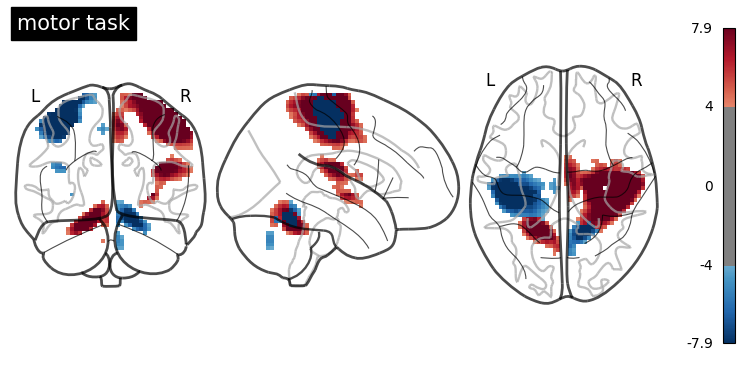

In [13]:
# Plot glass brain motor map
threshold = 4
plot_glass_brain(motor_stat, threshold=threshold,
                 plot_abs=False, title='motor task')

We can also change the [`display_mode`](https://nilearn.github.io/plotting/index.html#different-display-modes) for different arrangements; try replotting with `display_mode='lzr'`.

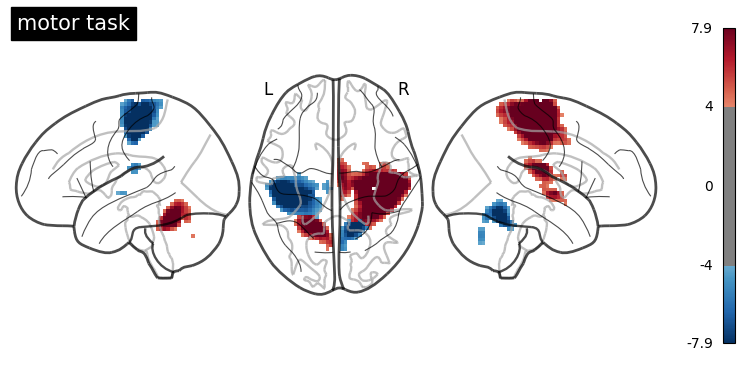

In [14]:
# Plot with a different display mode
display_mode = 'lzr'
plot_glass_brain(motor_stat, threshold=threshold, plot_abs=False,
                 display_mode=display_mode, title='motor task')

We can also visualize the statistical map using our familiar orthogonal slices using `plot_stat_map`. Here, an MNI template is used as the background image. Adjust the `cut_coords` variable to view different slices.

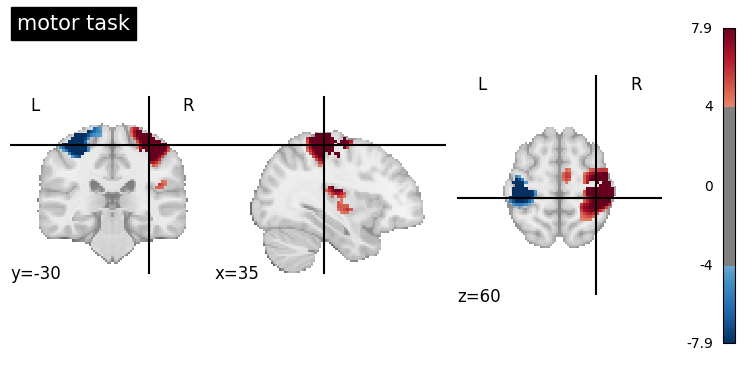

In [15]:
# Visualize motor map slices on MNI template
cut_coords = (35, -30, 60)
plot_stat_map(motor_stat, threshold=threshold,
              cut_coords=cut_coords, title="motor task")

Finally, we'll visualize the same data on a 2-dimensional representation of the cortical sheet. We first download [FreeSurfer](https://surfer.nmr.mgh.harvard.edu/)'s *fsaverage5* surface template, then project the volumetric data onto the surface. When run `plot_surf_stat_map`, you can use `fsaverage.pial_right` to view the statistical map on the folded pial surface, or you can use `fsaverage.infl_right` to use an inflated surface representation. Try making some adjustments to view the left surface as well.

In [16]:
fsaverage = datasets.fetch_surf_fsaverage('fsaverage5')

In [17]:
motor_surf = vol_to_surf(motor_stat, fsaverage.pial_right)

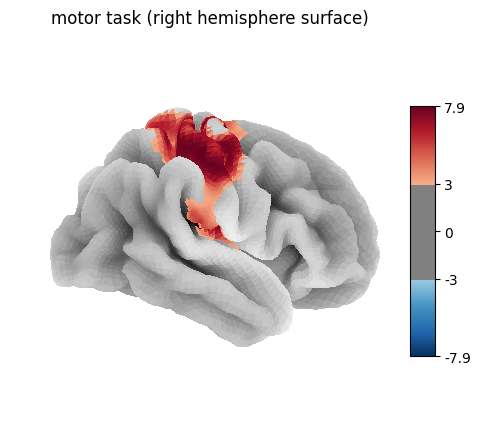

In [18]:
z_threshold = 3.0
plot_surf_stat_map(fsaverage.pial_right, motor_surf,
                   hemi='right', colorbar=True,
                   title='motor task (right hemisphere surface)',
                   threshold=3, bg_map=fsaverage.sulc_right);

#### References

* Haxby, J. V., Gobbini, M. I., Furey, M. L., Ishai, A., Schouten, J. L., & Pietrini, P. (2001). Distributed and overlapping representations of faces and objects in ventral temporal cortex. *Science*, 293(5539), 2425–2430. https://doi.org/10.1126/science.1063736

* Thirion, B., Varoquaux, G., Grisel, O., Poupon, C., & Pinel, P. (2014). Principal component regression predicts functional responses across individuals. In *International Conference on Medical Image Computing and Computer-Assisted Intervention* (pp. 741–748). https://doi.org/10.1007/978-3-319-10470-6_92